In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
from scipy import interpolate

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # changes per computer
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 05/05/2020 14:24:06


In [31]:
opt_parms = { 'ovs': 4096,
             'surf_units': u.micron,
             'ca': 75,
             'ring_width': 5}

parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')
oap=[]

n=0
fileloc = data_folder+'oap{0}_{1}CA'.format(oap_labels[n], opt_parms['ca'])
opt = psd.surfPSD(surf_name='OAP {0}'.format(oap_labels[n]))
opt.open_surf(fileloc=fileloc+'_surf.fits', surf_units = opt_parms['surf_units'])
opt.open_mask(fileloc=fileloc+'_mask.fits')
opt.calc_psd(oversamp = opt_parms['ovs'])
opt.calc_psd_radial(ring_width=opt_parms['ring_width'])

In [132]:
opt.delta_k * opt_parms['ring_width']

<Quantity 0.0072816 1 / mm>

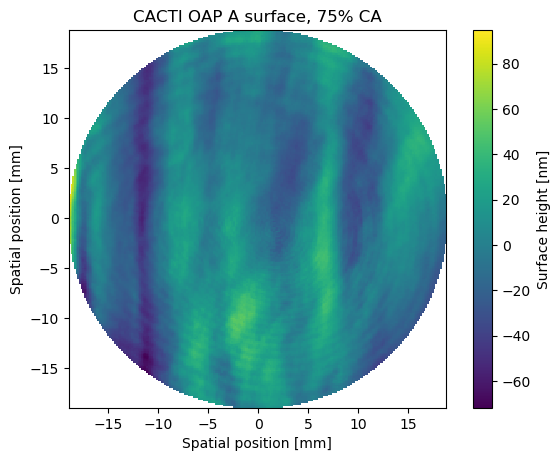

In [85]:
m = opt.mask.shape[0]/2
xylabel = (np.linspace(-m, m, m*2, endpoint=False)*opt.latres*u.pix).to(u.mm)

plt.figure(figsize=[7,5], dpi=100)
plt.imshow(dfx.sn_map(opt.data.to(u.nm).value, opt.mask), origin='lower',
          extent=[np.amin(xylabel.value), np.amax(xylabel.value), np.amin(xylabel.value), np.amax(xylabel.value)])
plt.xlabel('Spatial position [{0}]'.format(xylabel.unit))
plt.ylabel('Spatial position [{0}]'.format(xylabel.unit))
plt.title('CACTI OAP {0} surface, {1}% CA'.format(oap_labels[n], opt_parms['ca']))
plt.colorbar().set_label('Surface height [{0}]'.format(u.nm))

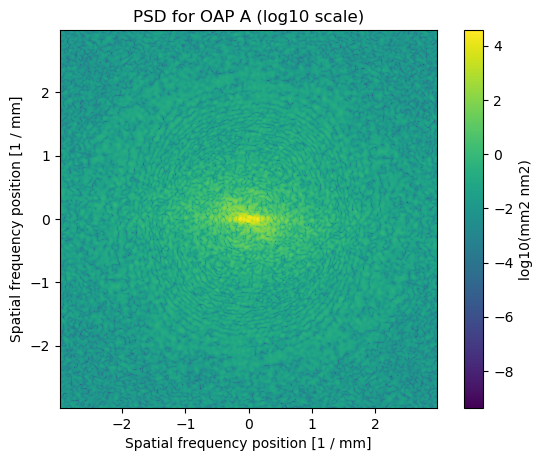

In [86]:
kxky_label=np.roll(np.fft.fftfreq(n=opt.oversamp, d=(opt.diam_ca/opt.npix_diam)), int(opt.oversamp/2))

plt.figure(figsize=[7,5], dpi=100)
plt.imshow(np.log10(opt.psd_cal.value), origin='lower',
           extent=[np.amin(kxky_label.value), np.amax(kxky_label.value), np.amin(kxky_label.value), np.amax(kxky_label.value)])
plt.title('PSD for OAP {0} (log10 scale)'.format(oap_labels[n]))
plt.xlabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
plt.ylabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
cbar = plt.colorbar()
cbar.set_label('log10({0})'.format(opt.psd_cal.unit))

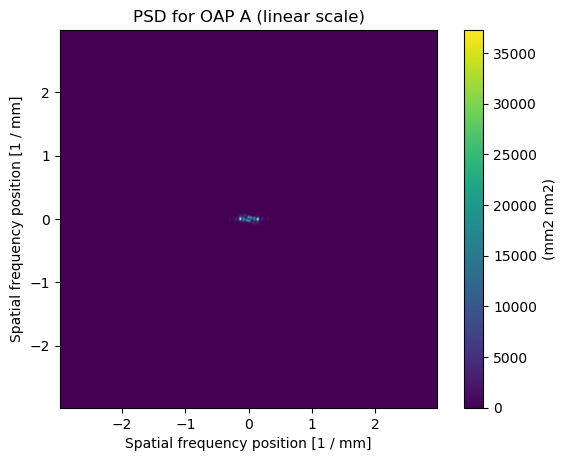

In [88]:
kxky_label=np.roll(np.fft.fftfreq(n=opt.oversamp, d=(opt.diam_ca/opt.npix_diam)), int(opt.oversamp/2))

plt.figure(figsize=[7,5], dpi=100)
plt.imshow((opt.psd_cal.value), origin='lower',
           extent=[np.amin(kxky_label.value), np.amax(kxky_label.value), np.amin(kxky_label.value), np.amax(kxky_label.value)])
plt.title('PSD for OAP {0} (linear scale)'.format(oap_labels[n]))
plt.xlabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
plt.ylabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
cbar = plt.colorbar()
cbar.set_label('({0})'.format(opt.psd_cal.unit))

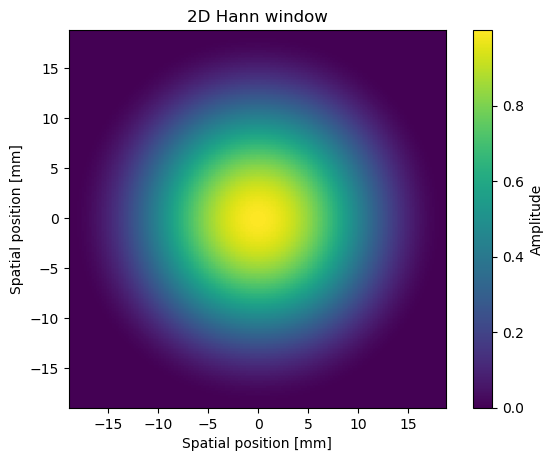

In [91]:
hw = psd.han2d((opt.npix_diam, opt.npix_diam)) * opt.mask

plt.figure(figsize=[7,5], dpi=100)
plt.imshow(hw, origin='lower',
          extent=[np.amin(xylabel.value), np.amax(xylabel.value), np.amin(xylabel.value), np.amax(xylabel.value)])
plt.xlabel('Spatial position [{0}]'.format(xylabel.unit))
plt.ylabel('Spatial position [{0}]'.format(xylabel.unit))
plt.title('2D Hann window')
plt.colorbar().set_label('Amplitude')

Text(0.5, 1.0, '1D cut through Hann window')

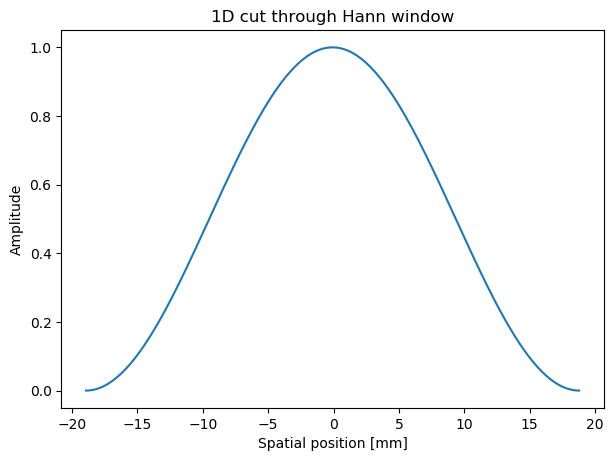

In [92]:
plt.figure(figsize=[7,5], dpi=100)
plt.plot(xylabel.value, hw[:, int(opt.npix_diam/2)])
plt.xlabel('Spatial position [{0}]'.format(xylabel.unit))
plt.ylabel('Amplitude')
plt.title('1D cut through Hann window')

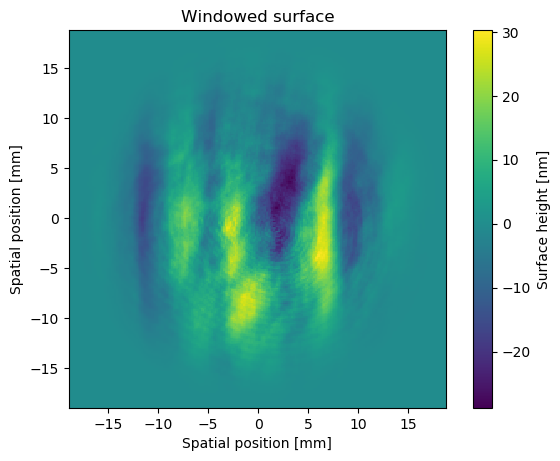

In [93]:
plt.figure(figsize=[7,5], dpi=100)
plt.imshow((opt.data.to(u.nm).value*hw), origin='lower',
            extent=[np.amin(xylabel.value), np.amax(xylabel.value), np.amin(xylabel.value), np.amax(xylabel.value)])
plt.xlabel('Spatial position [{0}]'.format(xylabel.unit))
plt.ylabel('Spatial position [{0}]'.format(xylabel.unit))
plt.title('Windowed surface')
plt.colorbar().set_label('Surface height [nm]')

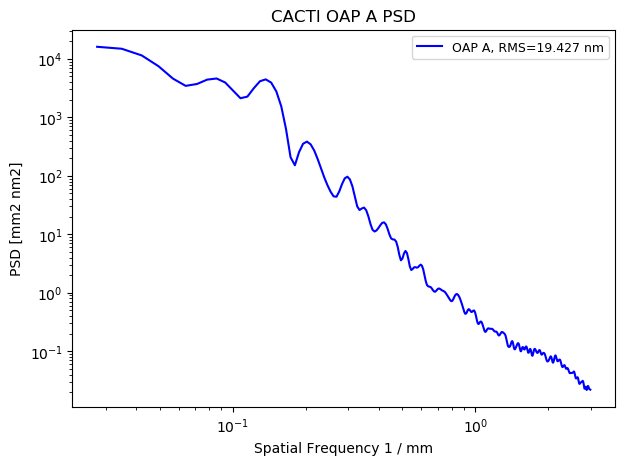

In [106]:
plt.figure(figsize=[7,5], dpi=100)
plt.loglog(opt.k_radial.value, opt.psd_radial_cal.value, 'b', label='{0}, RMS={1:.3f}'.format(opt.surf_name, opt.rms))
plt.
plt.xlabel('Spatial Frequency {0}'.format(opt.k_radial.unit))
plt.ylabel('PSD [{0}]'.format(opt.psd_radial_cal.unit))
plt.title('CACTI OAP A PSD')
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))

In [109]:
shift = np.int(opt.oversamp/2)
maskY, maskX = np.ogrid[-shift:shift, -shift:shift]

# set the limits
klim_lm = 1/(10*u.mm)
klim_mh = 1/(1*u.mm)

# calculate the element position
(b_l, k_l) = psd.k_locate(opt.radialFreq, opt.k_min)
(b_lm, k_lm) = psd.k_locate(opt.radialFreq, klim_lm)
width_low = b_lm - b_l
(b_mh, k_mh) = psd.k_locate(opt.radialFreq, klim_mh)
width_mid = b_mh - b_lm
(b_h, k_h) = psd.k_locate(opt.radialFreq, opt.k_max)
width_high = b_h - b_mh

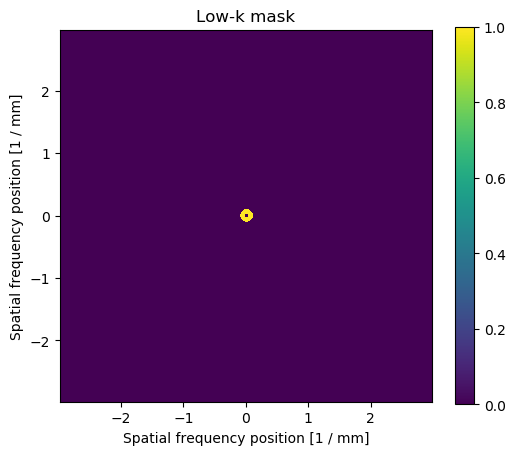

In [128]:
rlow = psd.makeRingMask(maskY, maskX, b_l, width_low).astype(int)
plt.figure(figsize=[6,5], dpi=100)
plt.imshow(rlow, origin='lower', #label='mid-k region',
           extent=[np.amin(kxky_label.value), np.amax(kxky_label.value), np.amin(kxky_label.value), np.amax(kxky_label.value)])
plt.title('Low-k mask')
plt.xlabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
plt.ylabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
plt.colorbar()

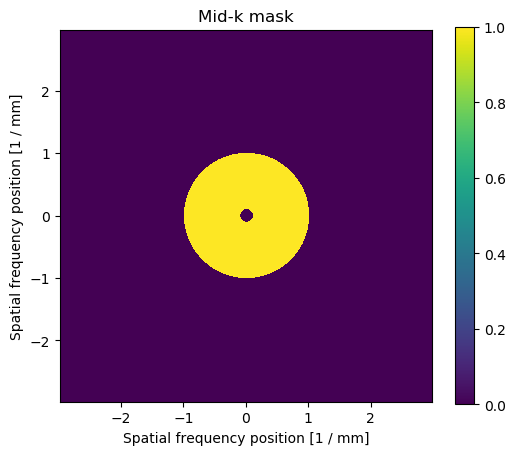

In [129]:
rmid = psd.makeRingMask(maskY, maskX, b_lm, width_mid).astype(int)
plt.figure(figsize=[6,5], dpi=100)
plt.imshow(rmid, origin='lower', label='mid-k region',
           extent=[np.amin(kxky_label.value), np.amax(kxky_label.value), np.amin(kxky_label.value), np.amax(kxky_label.value)])
plt.title('Mid-k mask')
plt.xlabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
plt.ylabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
plt.colorbar()

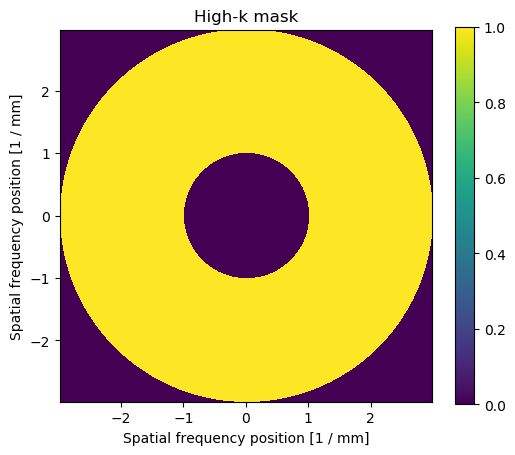

In [131]:
rhigh = psd.makeRingMask(maskY, maskX, b_mh, width_high).astype(int)
plt.figure(figsize=[6,5], dpi=100)
plt.imshow(rhigh, label='high-k region',
           extent=[np.amin(kxky_label.value), np.amax(kxky_label.value), np.amin(kxky_label.value), np.amax(kxky_label.value)])
plt.title('High-k mask')
plt.xlabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
plt.ylabel('Spatial frequency position [{0}]'.format(kxky_label.unit))
plt.colorbar()